In [24]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import copy
from graphing import Stocks

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random

""" Parameters """

SEED = 10

# all models
BACK_CANDLES = 60 # how many candles to use as input
SPLIT_RATIO = 0.8 # splitting between training and test
VALIDATION_SPLIT = 0.1

# Hyperparameters for multi layer model

BATCH_SIZE = 16
EPOCHS = 30
DROPOUT_LEVEL = 0.3
UNITS_LSTM1 = 128
UNITS_LSTM2 = 64
UNITS_LSTM3 = 32
LEARNING_RATE = 0.001

NUM_PREDICTIONS = 250 # future predictions

STOCK_NO = 0

def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

def calculate_indicators(df):
    df.bbCalc()
    df.rsiCalc()
    #df.maCalc(13)
    #df.stochRSICalc()
    df.macdCalc()
    return

# Set seeds for reproducibility
def set_seeds(seed=SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds()

# fetch data
file_path = "./prices.txt"
prcAll = loadPrices(file_path)
data = Stocks(prcAll)

# Adding indicators
calculate_indicators(data)
future_df = copy.deepcopy(data)
data = data.data[data.data['Stock'] == STOCK_NO]
future_df.data = future_df.data[future_df.data['Stock'] == STOCK_NO]
#print(data)

# calculate volatility of stock
data['Returns'] = data['Price'].pct_change()

data.set_index('Day', inplace=True)
future_df.data.set_index('Day', inplace=True)

# calculate targnextclose to use as test
data = data.copy()
data['TargetNextClose'] = data['Price'].shift(-1)
future_df.data['TargetNextClose'] = future_df.data['Price'].shift(-1)
# drop NaN rows
data.dropna(inplace=True)
future_df.data.dropna(inplace=True)
# reset index starting from 0 again to assist in calculations
data.reset_index(inplace = True)
future_df.data.reset_index(inplace=True)
print(future_df.whatToGraph) # TODO need to fix whatToGraph in graphing.py need to match features below

# after we dropna, we can calculate volatility
volatility = data['Returns'].std()
#print(volatility)

features = ['Price','21MA', 'Upper Band', 'Lower Band', 'RSI 14','MACD','MACD Signal','TargetNextClose']
data_set = data[features]
future_df.data = future_df.data[features]

# normalise the data
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)

# Preparing the feature set for the model
X = []

# Generate the feature set for each feature except the last one (which is the target)
for j in range(len(features) - 1):
    X.append([data_set_scaled[i - BACK_CANDLES:i, j] for i in range(BACK_CANDLES, data_set_scaled.shape[0])])

# Convert X to a numpy array and move the axis
X = np.moveaxis(X, [0], [2])

# Preparing the target variable
y = data_set_scaled[BACK_CANDLES:, -1].reshape(-1, 1)

X = np.array(X)
y = np.array(y)

# split data into train test sets
splitlimit = int(len(X) * SPLIT_RATIO)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


['Price', '21MA', '21MA', 'Upper Band', 'Lower Band', 'RSI', 'MACD', 'MACD Signal']
(335, 60, 7)
(84, 60, 7)
(335, 1)
(84, 1)


In [15]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from kerastuner import RandomSearch

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.optimizers import Adam
import numpy as np
#tf.random.set_seed(20)
#np.random.seed(10)
"""
lstm_input = Input(shape=(backcandles, 5), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
"""
from kerastuner import RandomSearch

def create_model(backcandles=BACK_CANDLES):
    lstm_input = Input(shape=(backcandles, len(features)-1), name='lstm_input')

    # first lstm layer with dropout
    x = LSTM(UNITS_LSTM1, return_sequences=True, name='first_layer')(lstm_input)
    x = Dropout(DROPOUT_LEVEL, name='first_dropout')(x)

    # second lstm layer with dropout
    x = LSTM(UNITS_LSTM2, return_sequences=True, name='second_layer')(x)
    x = Dropout(DROPOUT_LEVEL, name='second_dropout')(x)

    # third lstm layer with dropout
    x = LSTM(UNITS_LSTM3, name='third_layer')(x)
    x = Dropout(DROPOUT_LEVEL, name='third_dropout')(x)

    # dense layer and output
    x = Dense(1, name='dense_layer')(x)
    output=Activation('linear', name='output')(x)

    model = Model(inputs=lstm_input, outputs=output)
    return model

model = create_model()
# compile the model with the Adam optimiser
adam = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True, validation_split=VALIDATION_SPLIT)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0728 - val_loss: 0.0349
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0206 - val_loss: 0.0204
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0162 - val_loss: 0.0237
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0156 - val_loss: 0.0125
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0137 - val_loss: 0.0046
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0138 - val_loss: 0.0100
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0135 - val_loss: 0.0083
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0115 - val_loss: 0.0080
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0118 - val_loss: 0.0053
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0105 - val_loss: 0.0068
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0122 - val_loss: 0.0105
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

input shape: (1, 60, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
new row: Price              13.219045
21MA               13.081429
Upper Band         13.247113
Lower Band         12.915744
RSI 14             42.528736
MACD               -0.036596
MACD Signal        -0.020791
TargetNextClose    12.990000
Name: 399, dtype: float64
before calculations
         Price       21MA  Upper Band  Lower Band     RSI 14      MACD  \
0    13.590000  13.633333   13.830141   13.436525  45.744681  0.025734   
1    13.450000  13.632857   13.831467   13.434248  32.291667  0.009399   
2    13.580000  13.637619   13.825332   13.449906  41.509434  0.006865   
3    13.580000  13.642857   13.816540   13.469174  45.360825  0.004802   
4    13.570000  13.644762   13.814069   13.475455  48.351648  0.002332   
..         ...        ...         ...         ...        ...       ...   
396  13.060000  13.095714   13.223710   12.967719  44.705882 -0.008037   
397  13.040000  13.095238   13.224020   12.966456  50.00000

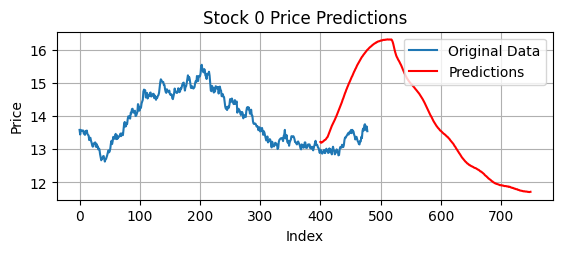

In [25]:
future_predictions = []
counter = 0
start = 400
end = 750
future_df.data = future_df.data.head(start)
diff = end-start
#print(future_df.data.tail(10))
for j in range(diff):
    latest_data = future_df.data.tail(BACK_CANDLES)
    latest_data_scaled = sc.transform(latest_data)
    #print(latest_data.shape)

    # create input sequence
    x_input = []
    for i in range(len(features)-1):
        x_input.append(latest_data_scaled[:, i])

    x_input = np.array(x_input).T
    x_input = np.expand_dims(x_input, axis=0)
    print(f"input shape: {x_input.shape}")

    # make predictions
    predicted_scaled_price = model.predict(x_input)
    predicted_price = sc.inverse_transform(
        np.concatenate([np.zeros((predicted_scaled_price.shape[0], data_set.shape[1]-1)), predicted_scaled_price], axis=1)
    )[:, -1]

    #print(predicted_price)
    future_predictions.append(predicted_price[0])

    # update latest data with the new predicted price
    new_row = latest_data.iloc[-1].copy()
    new_row['Price'] = predicted_price[0]
    print(f"new row: {new_row}")
    #print(future_df.data)
    future_df.data = pd.concat([future_df.data, pd.DataFrame([new_row])], ignore_index=True)

    #future_df.data = pd.concat([future_df.data, pd.DataFrame([new_row])], ignore_index=True)
    #print(future_df.data.iloc[j + BACK_CANDLES -5: j+BACK_CANDLES + 5])

    filler = np.zeros(len(future_df.data),dtype=np.int8)
    future_df.data['Stock'] = filler.tolist()
    print("before calculations")
    print(future_df.data)
    #print(future_df.data.iloc[j + BACK_CANDLES -5: j+BACK_CANDLES + 5])

    calculate_indicators(future_df)
    future_df.data['TargetNextClose'] = future_df.data['Price'].shift(-1)
    #print("after calculations")
    #print(future_df.data.iloc[j + BACK_CANDLES -5: j+BACK_CANDLES + 5])
    # only keep features
    future_df.data = future_df.data[features]


# Combine original data and future predictions for plotting
original_data = data_set['Price']
prediction_index = range(start, end)
predictions_df = pd.DataFrame({'Price': future_predictions}, index=prediction_index)

# TODO return these to calculate r2 of model
#y_pred_original_scale = y_pred_original_scale.reshape(-1, 1)
#print(y_pred_original_scale)
#print(np.array(future_df.data.tail(250).Price).reshape(-1, 1).shape)
all_predicted_values = np.array(future_df.data['Price'][start:end].copy())
#np.concatenate((y_pred_original_scale, np.array(future_df.data.tail(250).Price).reshape(-1, 1)), axis=0)
noise = np.random.uniform(-volatility, volatility, all_predicted_values.shape)
all_predicted_values += noise
#print(all_predicted_values)
# prediction_index = range(len(original_data)-len(y_test), len(original_data) + NUM_PREDICTIONS)
plt.subplot(2,1,2)
plt.plot(original_data, label='Original Data')
plt.plot(prediction_index, all_predicted_values, label='Predictions', color='red')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title(f'Stock {STOCK_NO} Price Predictions')
plt.legend()
plt.grid()
plt.show()